In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


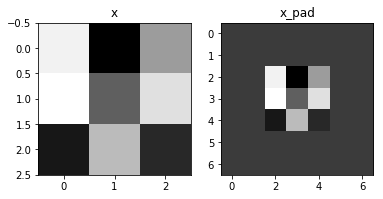

In [4]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.

    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions

    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    X_pad = np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),'constant')
    return X_pad
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [10]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.

    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """
    return np.sum(a_slice_prev*W)+b
np.random.seed(1)
a_slice_prev = np.random.randn(3,3,3)
W = np.random.rand(3,3,3)
b = np.random.randn(1,1,1)
conv_single_step(a_slice_prev,W,b)

array([[[ 0.11204057]]])

In [34]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function

    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"

    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape   # trick
    (f, f, n_C_prev, n_C) = W.shape
    
    s = hparameters['stride']
    p = hparameters['pad']
    
    n_H = int((n_H_prev -f+2*p)/s+1)
    n_W = int((n_W_prev -f+2*p)/s+1)
    
    z = np.zeros((m, n_H, n_W, n_C)) # attention
    
    A_prev_pad = zero_pad(A_prev,p)
    
    for i in range(m):
        a_prev = A_prev_pad[i,:,:,:]
        for j in range(n_H):
            for k in range(n_W):
                for l in range(n_C):
                    vert_start = s*j
                    hori_start = s*k
                    a_slice = a_prev[vert_start:vert_start+f,hori_start:hori_start+f,:]
                    z[i,j,k,l] = conv_single_step(a_slice,W[:,:,:,l],b[0,0,0,l])          
                
    assert(z.shape == (m, n_H, n_W, n_C))
    cache = (A_prev, W, b, hparameters)
    return z,cache
        
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.0489952035289
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [44]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer

    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")

    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters['f']
    stride = hparameters['stride']
    
    n_H = int((n_H_prev-f)/stride+1)
    n_W = int((n_W_prev-f)/stride+1)
    
    n_C = n_C_prev
    A = np.zeros((m,n_H, n_W, n_C))
    
    for i in range(m):
        for j in range(n_H):
            for k in range(n_W):
                for p in range(n_C):
                    vert_start = j * stride
                    horiz_start = k * stride
                    a_prev = A_prev[i, vert_start:vert_start+f, horiz_start:horiz_start+f, p]

                    # Use np.max/np.mean.
                    if mode == "max":
                        A[i, j, k, p] = np.max(a_prev)
                    elif mode == "average":
                        A[i, j, k, p] = np.mean(a_prev)
                        
    assert(A.shape == (m, n_H, n_W, n_C))
    cache = A_prev, hparameters
    return A,cache

np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)


mode = max
A = [[[[ 1.74481176  0.86540763  1.13376944]]]


 [[[ 1.13162939  1.51981682  2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


In [58]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function

    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()

    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    (m, n_H, n_W, n_C)=dZ.shape
    (A_prev, W, b, hparameters) = cache
    
    stride = hparameters['stride']
    pad = hparameters['pad']

    (f, f, n_C_prev, n_C) = W.shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)
    print(dA_prev_pad.shape)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = stride * h
                    hori_start = stride * w
                    
                    a_slice = a_prev_pad[vert_start:vert_start+f,hori_start:hori_start+f,:]
            
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    da_prev_pad[vert_start:vert_start+f,hori_start:hori_start+f,:] += W[:,:,:,c]*dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
                    
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad,pad:-pad,:]
        
    return dA_prev,dW,db

np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

(10, 8, 8, 3)
dA_mean = 1.45243777754
dW_mean = 1.72699145831
db_mean = 7.83923256462


In [64]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.

    Arguments:
    x -- Array of shape (f, f)

    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    return (x == np.max(x))
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)


x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


In [60]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape

    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz

    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    (n_H, n_W) = shape
    a = np.ones((n_H, n_W))*dz/(n_H*n_W)
    
    return a
a = distribute_value(2, (2,2))
print('distributed value =', a)
    
    

distributed value = [[ 0.5  0.5]
 [ 0.5  0.5]]


In [69]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer

    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")

    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache

    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    f = hparameters['f']

    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape

    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(np.shape(A_prev))

    for i in range(m):                       # loop over the training examples

        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i, :, :, :]

        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)

                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Compute the backward propagation in both modes.
                    if mode == "max":

                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask, dA[i, h, w, c])


                    elif mode == "average":

                        # Get the value a from dA (≈1 line)
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)

    ### END CODE ###

    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.145713902729
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
